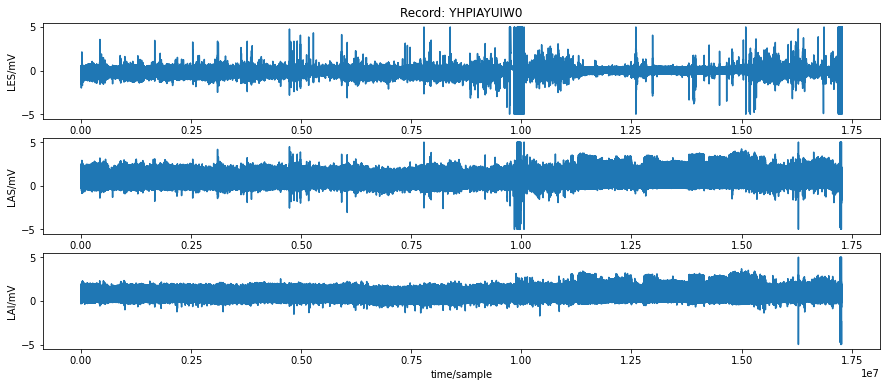

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wfdb
import statistics as st
from scipy.sparse import csr_matrix
from scipy.signal import find_peaks
from wfdb import processing
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve


fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
#print(plt.rcParams.get('figure.figsize'))

record = wfdb.rdrecord('YHPIAYUIW0') 
wfdb.plot_wfdb(record=record) 
#display(record.__dict__)

In [4]:
display(record.__dict__)

{'record_name': 'YHPIAYUIW0',
 'n_sig': 3,
 'fs': 200,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 17278098,
 'base_time': None,
 'base_date': None,
 'comments': ['Produced by snip from record Zymed, beginning at 0'],
 'sig_name': ['LES', 'LAS', 'LAI'],
 'p_signal': array([[ 0.4394475,  0.488275 , -0.2050755],
        [ 0.4394475,  0.488275 , -0.2050755],
        [ 0.429682 ,  0.4980405, -0.19531  ],
        ...,
        [ 4.9120465,  0.097655 ,  0.3027305],
        [ 4.941343 ,  0.1660135,  0.2831995],
        [ 4.941343 ,  0.2636685,  0.234372 ]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['YHPIAYUIW0.dat', 'YHPIAYUIW0.dat', 'YHPIAYUIW0.dat'],
 'fmt': ['16', '16', '16'],
 'samps_per_frame': [1, 1, 1],
 'skew': [None, None, None],
 'byte_offset': [None, None, None],
 'adc_gain': [102.401310737, 102.401310737, 102.401310737],
 'baseline': [0, 0, 0],
 'units': ['mV', 'mV', 'mV'],
 'adc_res': [10, 10, 10],
 'adc_zero': [0, 0, 0],
 'init_val

In [19]:
signals, fields = wfdb.rdsamp('YHPIAYUIW0', channels=[2])
record = wfdb.rdrecord('YHPIAYUIW0', channels=[2])
#record = wfdb.rdrecord('YHPFRM59DE', channels=[0])
signal=signals.reshape(record.sig_len)

In [20]:
def baseline_als(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) # Do not create a new matrix, just update diagonal values
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

In [21]:
signal_bas=baseline_als(signal[:int(len(signal)/2)],100,0.001)

In [22]:

signal_bas_2=baseline_als(signal[int(len(signal)/2):int(len(signal))],100,0.001)
sub_1=np.subtract(signal[:int(len(signal)/2)],signal_bas)
sub_2=np.subtract(signal[int(len(signal)/2):int(len(signal))],signal_bas_2)
signal_com=np.concatenate((sub_1,sub_2),None)

[]

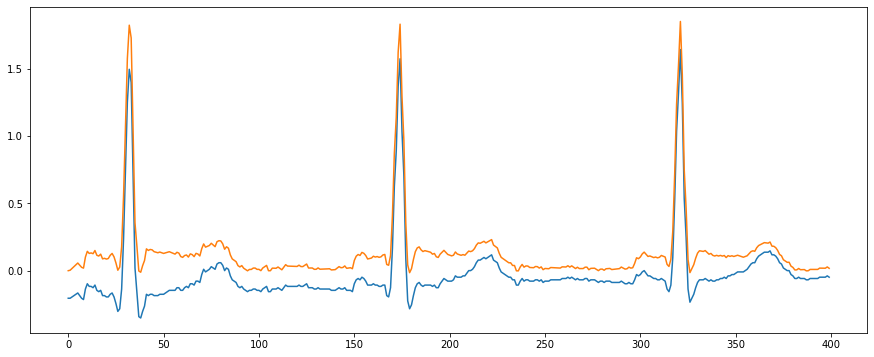

In [23]:
plt.plot(signal[:400])
plt.plot(signal_com[:400])
plt.plot()

In [10]:
signal_prep=pd.DataFrame(signal_com)
signal_prep_w=signal_prep.rolling(15).mean() 
x=signal_prep_w.values.reshape(record.sig_len)
peaks_1, _ = find_peaks(x[:15471177-79500+2240], height=(0.23))
peaks_2, _ = find_peaks(x[15471177-79500+2240:], height=(3))
peaks_2=peaks_2.reshape(len(peaks_2))+15471177-79500+2240

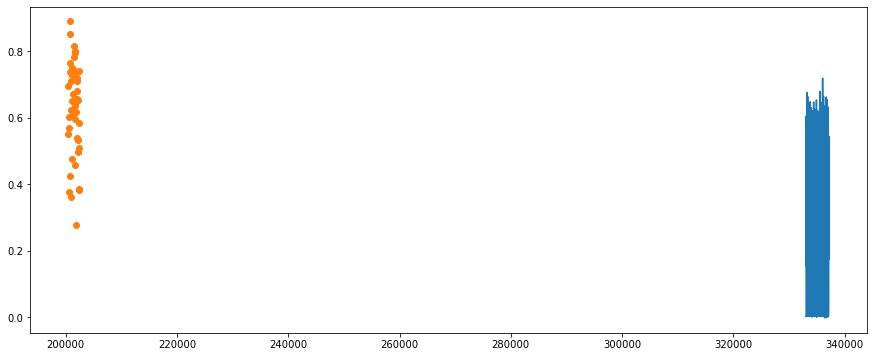

In [11]:
plt.plot(np.arange(333000,337200),signal_prep_w.values[333000:337200])
#plt.plot(signal[:4700], "--",)
plt.plot(peaks_1[4094:4140], signal_prep_w.values[peaks_1[4094:4140]], "o")
plt.show()

In [12]:
peaks=np.concatenate((peaks_1,peaks_2),None)

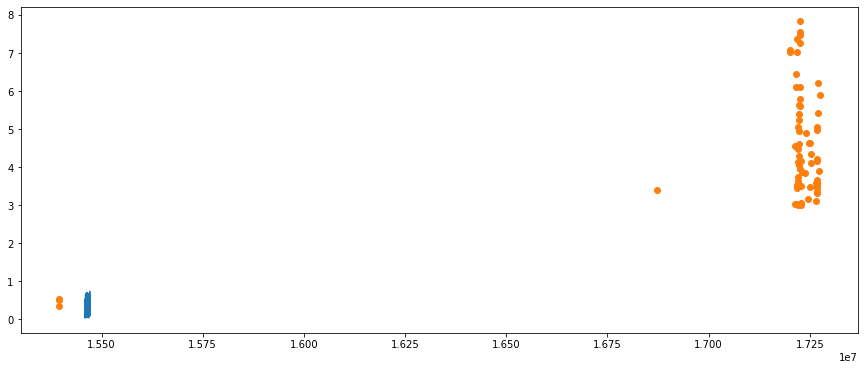

In [13]:
plt.plot(np.arange(15471177-79500+2240+65000,15471177),signal_prep_w.values[15471177-79500+2240+65000:15471177])
#plt.plot(signal[:4700], "--",)
plt.plot(peaks[-70:], signal_prep_w.values[peaks[-70:]], "o")
plt.show()

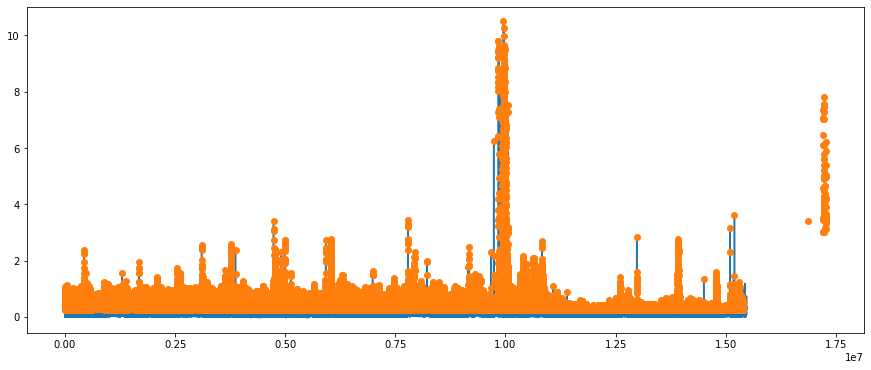

In [14]:
plt.plot(np.arange(15471177),signal_prep_w.values[:15471177])
#plt.plot(signal[:4700], "--",)
plt.plot(peaks, signal_prep_w.values[peaks], "o")
plt.show()

### Metricas de HRV en el dominio del tiempo

### SDNN

$$ SDNN= \sqrt\frac{\sum_{n=1}^{N}{[RR_{n}-\overline{RR}]^2}}{N-1}$$


In [ ]:
intervalosNN = np.zeros(peaks.shape)

for i in range(len(peaks)-1):
    intervalosNN[i]=peaks[i+1]-peaks[i]
st.stdev(intervalosNN)

### SDANN
$$ SDANN= \sqrt\frac{\sum_{n=1}^{N}{[\overline{RR_{n}}-\overline{\overline{RR}}]^2}}{N-1}$$


In [ ]:
num_seg=int(record.sig_len/(175*60*5))


In [117]:
Useg_5min=np.zeros(num_seg)
seg_5min=np.zeros(num_seg)
temp=0
for i in range(num_seg):
    Useg_5min[i]=temp
    temp=temp+52500

In [118]:
for j in range(len(Useg_5min)-1):
    picos=peaks[(peaks>Useg_5min[j]) & (Useg_5min[j+1]>=peaks)]
    intervalosNN5 = np.zeros(picos.shape)
    for i in range(len(picos)-1):
        intervalosNN5[i]=picos[i+1]-picos[i]
    if list(intervalosNN5):
        seg_5min[j]=np.nanmean(intervalosNN5)

In [119]:
st.stdev(seg_5min)

18.36315614102565

## SDNN Index

#### 1. Desviaciones estandar de los intervalos NN en los segmentos de 5 min

In [20]:
seg_5min_sd=np.zeros(num_seg)
for j in range(len(Useg_5min)-1):
    picos=peaks[(peaks>Useg_5min[j]) & (Useg_5min[j+1]>=peaks)]
    intervalosNN5 = np.zeros(picos.shape)
    for i in range(len(picos)-1):
        intervalosNN5[i]=picos[i+1]-picos[i]

    seg_5min_sd[j]=st.stdev(intervalosNN5)

StatisticsError: variance requires at least two data points

In [21]:
np.mean(seg_5min_sd)

29.731644974217282

## pNN50

In [22]:
countnn50=0
for i in range(len(intervalosNN)-1):
    if (abs(intervalosNN[i+1]-intervalosNN[i]))>10:
        countnn50+=1
        

In [23]:
countnn50

255124

In [24]:
countnn50/len(intervalosNN)*100

20.586104113444502

## RMSSD

In [25]:
Sum=0
for i in range(len(intervalosNN)-1):
    Sum=Sum+abs(intervalosNN[i+1]-intervalosNN[i])**2

In [26]:
np.sqrt(Sum/len(intervalosNN))

881.076672148517

In [27]:
from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values


In [28]:
from hrvanalysis import get_time_domain_features
time_domain_features = get_time_domain_features(intervalosNN[intervalosNN!=0])


In [29]:
time_domain_features['rmssd']

881.0773829469119

In [30]:
_5MINTEST=find_peaks(x[52500:105000], height=(0.23))

In [31]:
import pyhrv.tools as tools
nni = tools.nn_intervals(peaks)

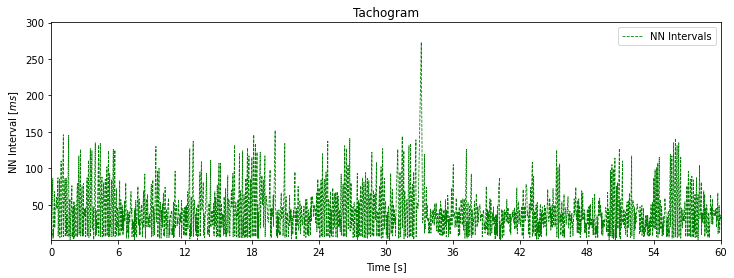

ReturnTuple(tachogram_plot=<Figure size 864x288 with 1 Axes>)

In [32]:
import pyhrv
pyhrv.tools.tachogram(nni=nni,hr=False,sampling_rate=175, interval=[0,60.0])

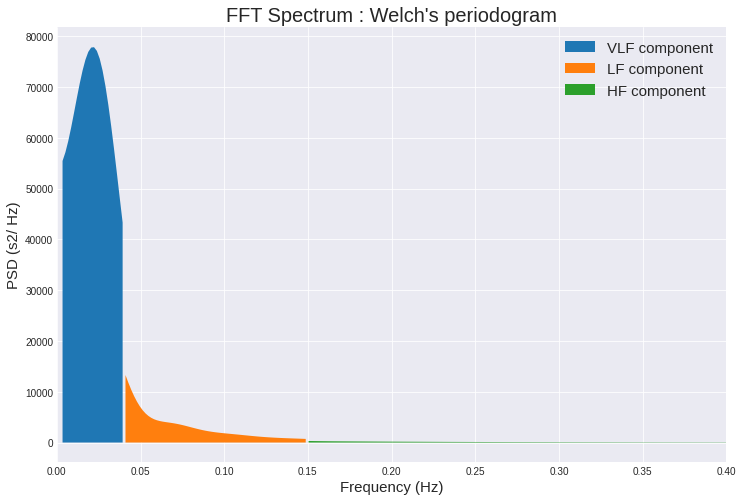

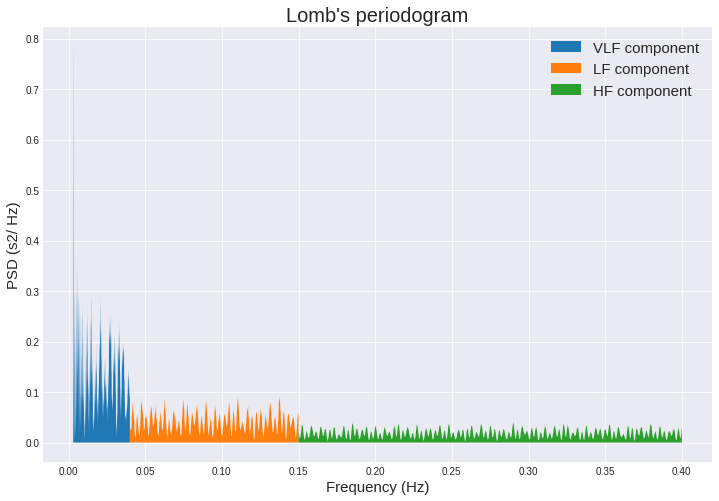

In [33]:
from hrvanalysis import plot_psd
plot_psd(nni, method="welch")
plot_psd(nni, method="lomb")

In [34]:
from hrvanalysis import get_frequency_domain_features,get_geometrical_features
get_frequency_domain_features(nni[:])

{'lf': 34605579.166103266,
 'hf': 7540559.410630051,
 'lf_hf_ratio': 4.589258870809931,
 'lfnu': 82.1085402713671,
 'hfnu': 17.891459728632885,
 'total_power': 201040448.682004,
 'vlf': 158894310.10527068}

In [35]:
get_geometrical_features(nni)

{'triangular_index': 137700.11111111112, 'tinn': None}

In [46]:
import pywt
A,B=pywt.dwt(signal,'db1','zero')

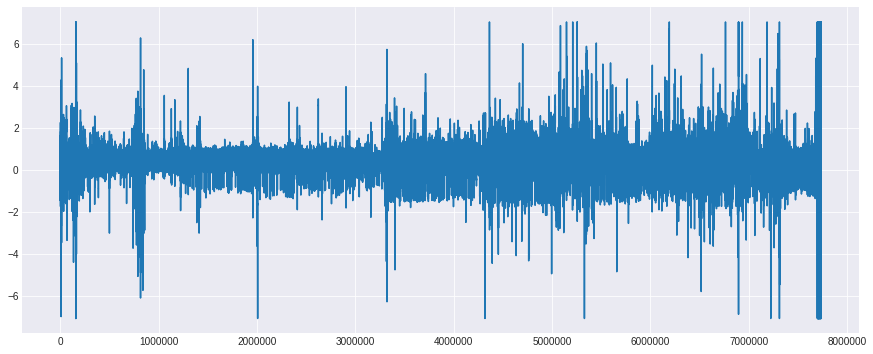

In [47]:
plt.plot(A)

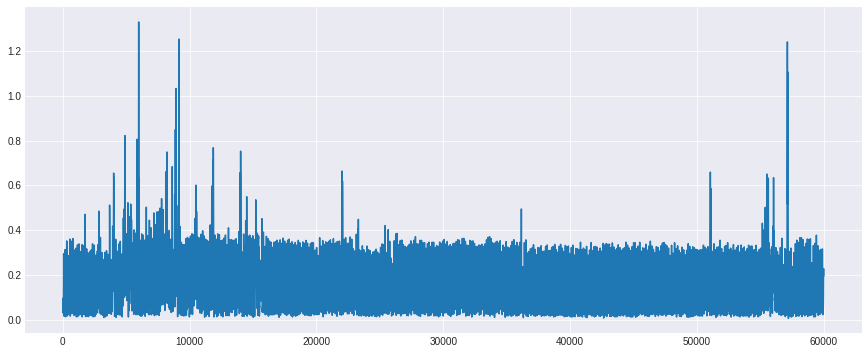

In [48]:
plt.plot(signal_prep_w.values[60000:120000])